# Project Title
### Data Engineering Capstone Project

#### Project Summary
The aim of this project is to use data sources for global temperature and U.S. demographics and create a database where data scientists can freely investigate global temperature changes. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
from pyspark.sql.functions import desc,year, month, dayofmonth, weekofyear, monotonically_increasing_id
import psycopg2
from create_insert_snowflake_schema import drop_snowflake_schema, create_snowflake_schema, copy_snowflake_schema, copy_locations
from create_insert_snowflake_schema import data_quality_snowflake_schema
from create_insert_analytics_tables import drop_analytics_tables
from create_insert_analytics_tables import create_analytics_tables
from create_insert_analytics_tables import insert_analytics_tables
from create_insert_analytics_tables import analytics_tables
import os
from IPython.display import Image

### Step 1: Scope the Project and Gather Data

#### Scope 
The project at hand aims to create a database for users to explore global temperature changes. It has been used two particular sources: temperature csv data from Kaggle (https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) and csv file with U.S. demographic statistics from OpenDataSoft (https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).  The final solution is based on both datasets and represents snowflake schema that contains three dimension tables 'location', 'time', and 'us_demographics' and one fact table 'temperature'. These are used to create an exemplary OLAP cube with four tables, showcasing analytical possibilities. Spark has been used in order to clean and save data. The creation of snowflake and analtical tables has been done in Postgres.

#### Describe and Gather Data 
As mentioned in the previous section, there are two types of datasets used in this project. The first one contains daily observations of temperatures with estimate uncetainty per global city. The information in this file is gather by Berkeley Earth and posted on kaggle website for free exploration. The csv file comprises of four columns - date in format 'YYYY-MM-DD', average temperature as number, average temperature uncertainty as float, city and countries as strings. 

The other dataset contains population statistics per city in United States. These include city and state as strings, total, female and population, number of foreign born and number of veterans as integers, median age as number and finally, race and integer counts of each race. The data is collected by U.S. Census Bureau as part of 2015 American Community Survey.

In [2]:
fname_temp = '../../data2/GlobalLandTemperaturesByCity.csv'
fname_demo = 'us-cities-demographics.csv'

### Step 2: Explore and Assess the Data
#### Explore the Data 
The two datasets are investigated in this section. There are few issues identified such as data quality issues, like missing values, duplicate data.

#### Cleaning Steps
All three steps are performed below - analysing, cleaning and saving the clean data into parquet files. As this interactive process, each data issue is handled immediately.

In [3]:
	
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [4]:
df_temp = spark.read.csv(fname_temp, header=True, mode='DROPMALLFORMED')
df_temp.show(5)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



Loading the temperature data, it is obvious right away there are missing values in the dataset. It will be addressed shortly.

In [5]:
df_demo = spark.read.csv(fname_demo, header=True, mode='DROPMALLFORMED', sep=';')
df_demo.show(5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

The US demographics does not show any immediate issue but will be drilled into later.

In [6]:
df_temp.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [7]:
df_demo.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



Both dataframes have their columns are loaded as strings. This, together the column name convention, is fixed for the temperature set first

In [8]:
df_temp = df_temp.withColumnRenamed('AverageTemperature', 'average_temperature') \
                .withColumnRenamed('AverageTemperatureUncertainty', 'average_temperature_uncertainty') \
                .withColumnRenamed('City', 'city') \
                .withColumnRenamed('Country', 'country') \
                .withColumnRenamed('Latitude', 'latitude') \
                .withColumnRenamed('Longitude', 'longitude')

In [9]:
df_temp = df_temp.withColumn('average_temperature', df_temp.average_temperature.cast('float')) \
                .withColumn('average_temperature_uncertainty', df_temp.average_temperature_uncertainty.cast('float')) \
                .withColumn('latitude', df_temp.latitude.cast('float')) \
                .withColumn('longitude', df_temp.longitude.cast('float')) \
                .withColumn('dt', df_temp.dt.cast('date'))

In [10]:
df_temp.printSchema()

root
 |-- dt: date (nullable = true)
 |-- average_temperature: float (nullable = true)
 |-- average_temperature_uncertainty: float (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



In [11]:
df_temp.describe('country').show()
#min and max are real countries

+-------+-----------+
|summary|    country|
+-------+-----------+
|  count|    8599212|
|   mean|       null|
| stddev|       null|
|    min|Afghanistan|
|    max|   Zimbabwe|
+-------+-----------+



The min and max values for country are real country names. No values are missing.

In [12]:
df_temp.groupBy('country').count().orderBy(desc('count')).show()
#no nonsense countries

+--------------+-------+
|       country|  count|
+--------------+-------+
|         India|1014906|
|         China| 827802|
| United States| 687289|
|        Brazil| 475580|
|        Russia| 461234|
|         Japan| 358669|
|     Indonesia| 323255|
|       Germany| 262359|
|United Kingdom| 220252|
|        Mexico| 209560|
|       Nigeria| 172347|
|         Spain| 159594|
|          Iran| 151651|
|        Turkey| 150306|
|      Pakistan| 139231|
|         Italy| 136038|
|   Philippines| 127700|
|        Poland| 123082|
|        France| 116604|
|  South Africa|  94050|
+--------------+-------+
only showing top 20 rows



Further investigation into country names shows no nonsense names. Also, given that China, United States and Germany are among the countries with most number of observations. As representative of different continents, they will be analysed in more details later.

In [13]:
df_temp.describe('average_temperature').show()

+-------+-------------------+
|summary|average_temperature|
+-------+-------------------+
|  count|            8235082|
|   mean| 16.727432636172175|
| stddev| 10.353442482004583|
|    min|            -42.704|
|    max|             39.651|
+-------+-------------------+



Looking at average temperature data, values seem to be valid with normal limit for min and max temperature across the world. However, there are missing values.

In [14]:
df_temp.describe('average_temperature_uncertainty').show()

+-------+-------------------------------+
|summary|average_temperature_uncertainty|
+-------+-------------------------------+
|  count|                        8235082|
|   mean|             1.0285747414276099|
| stddev|             1.1297332887072544|
|    min|                          0.034|
|    max|                         15.396|
+-------+-------------------------------+



The same conclusion holds for temperature uncertainty as average temperature data.

In [15]:
df_temp.where('country is null').count()/df_temp.count()

0.0

In [16]:
df_temp.where('city is null').count()/df_temp.count()

0.0

In [17]:
df_temp.where("country =''").count()/df_temp.count()

0.0

In [18]:
df_temp.where("city =''").count()/df_temp.count()

0.0

In [19]:
df_temp.where("average_temperature is null").count()/df_temp.count()

0.04234457761943769

In [20]:
df_temp.where("average_temperature_uncertainty is null").count()/df_temp.count()

0.04234457761943769

The six cells above confirms that the there are no null values or empty strings for cities and countries. However, 4.23% of the whole temperature population is made of null values.

In [21]:
df_temp = df_temp.dropDuplicates()

Few cleaning actions will be taken. First, removing rows with all duplicated values. Next, investigate if there are records with the same city, country and date but different temperatures. If there are, they are removed for the dataset as well.

In [22]:
df_temp.select(['city', 'country', 'dt']).groupBy(['city', 'country', 'dt']).count().orderBy(desc('count')).show()
#are there locations that have different measurements on the same date

+-----------+-------------+----------+-----+
|       city|      country|        dt|count|
+-----------+-------------+----------+-----+
|  Rongcheng|        China|1877-02-01|    3|
|Springfield|United States|1773-06-01|    3|
|Springfield|United States|1788-04-01|    3|
|  Rongcheng|        China|2007-12-01|    3|
|Springfield|United States|1965-08-01|    3|
|Springfield|United States|1920-09-01|    3|
|Springfield|United States|1795-04-01|    3|
|Springfield|United States|1995-03-01|    3|
|  Rongcheng|        China|1920-04-01|    3|
|Springfield|United States|1921-10-01|    3|
|  Rongcheng|        China|1864-06-01|    3|
|Springfield|United States|1832-05-01|    3|
|  Rongcheng|        China|1937-03-01|    3|
|  Rongcheng|        China|1957-01-01|    3|
|  Rongcheng|        China|1947-04-01|    3|
|Springfield|United States|1970-05-01|    3|
|  Rongcheng|        China|1849-12-01|    3|
|  Rongcheng|        China|1966-01-01|    3|
|Springfield|United States|1808-04-01|    3|
|Springfie

In [23]:
df_temp.where("city = 'Rongcheng' and country = 'China' and dt = '1855-10-01'").show()

+----------+-------------------+-------------------------------+---------+-------+--------+---------+
|        dt|average_temperature|average_temperature_uncertainty|     city|country|latitude|longitude|
+----------+-------------------+-------------------------------+---------+-------+--------+---------+
|1855-10-01|             21.515|                          2.588|Rongcheng|  China|    null|     null|
|1855-10-01|             11.163|                          1.855|Rongcheng|  China|    null|     null|
|1855-10-01|             16.757|                          1.717|Rongcheng|  China|    null|     null|
+----------+-------------------+-------------------------------+---------+-------+--------+---------+



In [24]:
df_temp = df_temp.dropDuplicates(subset=['city', 'country', 'dt'])

Verifying removing of duplicates:

In [25]:
df_temp.select(['city', 'country', 'dt']).groupBy(['city', 'country', 'dt']).count().orderBy(desc('count')).show()

+------------+-------------+----------+-----+
|        city|      country|        dt|count|
+------------+-------------+----------+-----+
|      Abohar|        India|1958-10-01|    1|
|      Akashi|        Japan|1909-05-01|    1|
|       Aktau|   Kazakhstan|1914-12-01|    1|
|     Aligarh|        India|1856-07-01|    1|
|   Allahabad|        India|1937-10-01|    1|
|   Amsterdam|  Netherlands|1878-08-01|    1|
|       Anand|        India|1938-09-01|    1|
|     Angarsk|       Russia|1865-09-01|    1|
|     Antioch|United States|1980-08-01|    1|
|     Antwerp|      Belgium|1910-03-01|    1|
|   Apucarana|       Brazil|1859-08-01|    1|
|      Aqtöbe|   Kazakhstan|1915-10-01|    1|
|       Asyut|        Egypt|1852-05-01|    1|
|      Athens|       Greece|1800-01-01|    1|
|       Bacau|      Romania|1815-04-01|    1|
|     Bacolod|  Philippines|1880-02-01|    1|
|Bahia Blanca|    Argentina|2002-04-01|    1|
|      Baiyin|        China|2000-05-01|    1|
|        Baku|   Azerbaijan|1866-1

Lastly, records with null values for any of the attributes is removed and check is performed to make sure there are no more missing values. The reason for removing null values instead of taking zeros or averages, for example, is that these numbers will enter calculations yet unknown. Thus, we cannot predict if average across week, month, year, city or country is better. This is why, the least impact on derivations later on will have deleting these records.

In [26]:
df_temp = df_temp.dropna(subset=['city', 'country', 'dt', 'average_temperature', 'average_temperature_uncertainty'])

In [27]:
df_temp.where("average_temperature is null").count()/df_temp.count()

0.0

In order to spin off time dataset, columns for year, month, day and week are added.

In [28]:
df_temp = df_temp.withColumn('year', year(df_temp.dt)) \
                .withColumn('month', month(df_temp.dt)) \
                .withColumn('day', dayofmonth(df_temp.dt)) \
                .withColumn('week', weekofyear(df_temp.dt))

In [29]:
df_temp.printSchema()

root
 |-- dt: date (nullable = true)
 |-- average_temperature: float (nullable = true)
 |-- average_temperature_uncertainty: float (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- week: integer (nullable = true)



Turning to the U.S. demographics dataset, column names are renamed to follow easy to refer convention. Also, as all attributes are loaded as strings, the format of each column is changed.

In [30]:
df_demo = df_demo.withColumnRenamed('City', 'city') \
            .withColumnRenamed('State', 'state') \
            .withColumnRenamed('Median Age', 'median_age') \
            .withColumnRenamed('Male Population', 'male_population') \
            .withColumnRenamed('Female Population', 'female_population')\
            .withColumnRenamed('Total Population', 'total_population')\
            .withColumnRenamed('Number of Veterans', 'number_of_veterans')\
            .withColumnRenamed('Foreign-born', 'foreign_born')\
            .withColumnRenamed('Average Household Size', 'average_household')\
            .withColumnRenamed('State Code', 'state_code')\
            .withColumnRenamed('Race', 'race')\
            .withColumnRenamed('Count', 'cnt')            

In [31]:
df_demo = df_demo.withColumn('median_age', df_demo.median_age.cast('float')) \
                .withColumn('male_population', df_demo.male_population.cast('int')) \
                .withColumn('female_population', df_demo.female_population.cast('int')) \
                .withColumn('total_population', df_demo.total_population.cast('int')) \
                .withColumn('number_of_veterans', df_demo.number_of_veterans.cast('int')) \
                .withColumn('foreign_born', df_demo.foreign_born.cast('int')) \
                .withColumn('average_household', df_demo.average_household.cast('float')) \
                .withColumn('cnt', df_demo.cnt.cast('int'))

In [32]:
df_demo.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: float (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- number_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- average_household: float (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- cnt: integer (nullable = true)



In [33]:
df_demo.select('city').describe().show()

+-------+-------+
|summary|   city|
+-------+-------+
|  count|   2891|
|   mean|   null|
| stddev|   null|
|    min|Abilene|
|    max|   Yuma|
+-------+-------+



There are no missing values for city and the min and max represent actual city names.

In [34]:
df_demo.select('state').describe().show()

+-------+---------+
|summary|    state|
+-------+---------+
|  count|     2891|
|   mean|     null|
| stddev|     null|
|    min|  Alabama|
|    max|Wisconsin|
+-------+---------+



The same conlcusion holds for states as for cities.

In [35]:
df_demo.where('city is null').count()/df_demo.count()

0.0

In [36]:
df_demo.where('state is null').count()/df_demo.count()

0.0

In [37]:
df_demo.where('median_age is null').count()

0

In [38]:
df_demo.where('male_population is null').count()

3

In [39]:
df_demo.where('female_population is null').count()

3

In [40]:
df_demo.where('total_population is null').count()

0

In [41]:
df_demo.where('cnt is null').count()

0

In [42]:
df_demo.where('state_code is null').count()

0

The eight cells above show that there are missing values only for female and male population variables.

Given that race and number of people per individual race are not nessesary, these will be dropped.

In [43]:
df_demo = df_demo.drop('race', 'cnt')

Duplicates of state and city are also removed.

In [44]:
df_demo = df_demo.dropDuplicates(subset=['city', 'state'])

The null values found in the two population variables are replaced with zeros. These are not essential attributes but still interesting information to have, so they will not be removed.

In [45]:
df_demo = df_demo.fillna(0)

In [46]:
df_demo.show()

+--------------------+--------------+----------+---------------+-----------------+----------------+------------------+------------+-----------------+----------+
|                city|         state|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household|state_code|
+--------------------+--------------+----------+---------------+-----------------+----------------+------------------+------------+-----------------+----------+
|          Cincinnati|          Ohio|      32.7|         143654|           154883|          298537|             13699|       16896|             2.08|        OH|
|         Kansas City|        Kansas|      33.4|          74606|            76655|          151261|              8139|       25507|             2.71|        KS|
|           Lynchburg|      Virginia|      28.7|          38614|            41198|           79812|              4322|        4364|             2.48|        VA|
|              Auburn|    Washingt

Next, the two dataframes need to be split into four tables. The location dimension table contains only distinct values for country, city, longitude and latitude. It also needs location_id which created by monotonically increasing function starting at 1. One last modification of the location table is to fill in zeros for missing latitude and longitude values.

In [47]:
df_loc = df_temp.select(['country', 'city', 'longitude', 'latitude']).groupBy('country', 'city', 'longitude', 'latitude').count()['country', 'city', 'longitude', 'latitude']

In [48]:
df_loc = df_loc.withColumn('location_id', monotonically_increasing_id()+1) \
                .select('location_id', 'country', 'city', 'longitude', 'latitude')

In [49]:
df_loc = df_loc.fillna(0)

In [50]:
df_loc.show(5)

+-----------+---------+-------+---------+--------+
|location_id|  country|   city|longitude|latitude|
+-----------+---------+-------+---------+--------+
|          1|     Oman|Salalah|      0.0|     0.0|
|          2|Argentina|Posadas|      0.0|     0.0|
|          3|    India| Jhansi|      0.0|     0.0|
|          4|    China| Jiutai|      0.0|     0.0|
|          5|    China| Bozhou|      0.0|     0.0|
+-----------+---------+-------+---------+--------+
only showing top 5 rows



Partition on the generic file is made by year, month and dates as the data distrbution across these expected to be not too different. Of course, the recent dates provbly have more points as cities are added to the sample but this is believed not to have a significant impact.

In [51]:
df_temp = df_temp.repartition("year", "month", "day")

Next, create a dataframe with distinct values for all dates from the temperature data. Adding also columns for year, month, day and week.

In [52]:
df_time = df_temp.select(['dt', 'year', 'month', 'day', 'week']).groupBy('dt', 'year', 'month', 'day', 'week').count().orderBy('dt')['dt', 'year', 'month', 'day', 'week']

In [53]:
df_time.show(5)

+----------+----+-----+---+----+
|        dt|year|month|day|week|
+----------+----+-----+---+----+
|1743-11-01|1743|   11|  1|  44|
|1744-04-01|1744|    4|  1|  14|
|1744-05-01|1744|    5|  1|  18|
|1744-06-01|1744|    6|  1|  23|
|1744-07-01|1744|    7|  1|  27|
+----------+----+-----+---+----+
only showing top 5 rows



In order for the end tables temperature and location to be joinable, they have to have column location_id. This is why the location dataset is joined on city and country so that the temperature dataset will identify the correct location_id. Later, the final temperature dataframe is spun off with date, average temperature, uncertainty and location_id attributes.

In [54]:
df_loc_temp = df_loc.withColumnRenamed('country', 'country_loc')\
                    .withColumnRenamed('city', 'city_loc')\
                    .select(['location_id', 'country_loc', 'city_loc'])

In [55]:
df_temp = df_temp.join(df_loc_temp, (df_temp.city == df_loc_temp.city_loc) & (df_temp.country == df_loc_temp.country_loc), how = 'left' )

In [56]:
df_temp = df_temp.select('dt', 'average_temperature', 'average_temperature_uncertainty', 'location_id')
df_temp.show()

+----------+-------------------+-------------------------------+-------------+
|        dt|average_temperature|average_temperature_uncertainty|  location_id|
+----------+-------------------+-------------------------------+-------------+
|2005-12-01|             -1.757|                          0.292|1271310319622|
|1901-03-01|              2.071|                          0.355|1271310319622|
|1812-09-01|             14.724|                          1.097|1271310319622|
|1989-01-01|             -0.429|                          0.283|1271310319622|
|1930-02-01|              0.108|                          0.205|1271310319622|
|1921-10-01|             10.807|                          0.289|1271310319622|
|1967-04-01|              8.633|                          0.251|1271310319622|
|1761-11-01|              4.249|                          3.272|1271310319622|
|1798-06-01|             21.073|                          1.807|1271310319622|
|1958-03-01|              2.764|                    

Taking up the U.S. demographics dataframe, it currently can joined to location only based on city as country is by definiton 'United States'. This is not good enough and this is why a temporary subset of the location table is made where the country is pre-filtered to be 'United States'. By joining to U.S. demographics table, the correct location_id is added. Next, a monotically increasing id as us_location_id is also added as a primary key and null location_id are set to zero. This should be a problem for the join as all id columns start at 1.

In [57]:
df_loc_temp_us = df_loc_temp.where("country_loc == 'United States'")

In [58]:
df_demo = df_demo.join(df_loc_temp_us, df_demo.city==df_loc_temp_us.city_loc, how='left')

In [59]:
df_demo = df_demo.drop('country_loc', 'city_loc')

In [60]:
df_demo = df_demo.withColumn('us_location_id', monotonically_increasing_id()+1)

In [61]:
df_demo = df_demo.fillna(0)

In [62]:
df_demo.show()

+--------------------+--------------+----------+---------------+-----------------+----------------+------------------+------------+-----------------+----------+-------------+--------------+
|                city|         state|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household|state_code|  location_id|us_location_id|
+--------------------+--------------+----------+---------------+-----------------+----------------+------------------+------------+-----------------+----------+-------------+--------------+
|        Saint George|          Utah|      37.3|          38732|            41475|           80207|              4443|        4824|             2.81|        UT|            0|             1|
|               Tyler|         Texas|      33.9|          50422|            53283|          103705|              4813|        8225|             2.59|        TX|            0|             2|
|           Worcester| Massachusetts|      34.9|  

The four cells below show the counts of the final snowflake tables. These will be used for data quality checks if the data pipeline from spark to Postgres has worked correctly.

In [63]:
df_temp.count()

8190455

In [64]:
df_loc.count()

3490

In [65]:
df_time.count()

3167

In [66]:
df_demo.count()

596

Finally, csv files have been created to store the four tables. The reason for using csv and parquet, for example, is discussed below.

In [67]:
df_temp.write.csv('temperature.csv', header='true')

In [68]:
df_loc.write.csv('location.csv', header='true')

In [69]:
df_time.write.csv('time.csv', header='true')

In [70]:
df_demo.write.csv('us_demographics.csv', header='true')

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

The aim of the project is to create a playground for data scientists to investigate trends for global temperature changes. With this in mind, the conceptual data model chosen for this project is a snowflake schema. It represents three dimension tables and one fact table. The dimension tables are Location, Time and US_demographics. Two of them describe particular feature of the fact table (Location and Time tables) and one of them describes further another of the dimension tables. That is US_demograpics has further information about Location table.  

The reason for choosing snowflake schema as a data model is that it is intuitve and easy to understand by users as compared to normalized data model. Also, it has been decided to choose snowflake and not snowflake schema because the nature of the us_demographics table is that brings extra information only for very small subset of the Location table. If these attributes are added to the Location table directly, it will result in much bigger table with a lot of null values. The size on disc would increase without adding any actual benefit. The U.S. subset will be used only for specific purposes such as which city has the greatest number of citizens to target for a marketing campaign about global warming. Its use is very limited and thus better be spun off.

The data model is being presented graphically below.

As an example of possible analysis based on the proposed data model, four analytic tables have been made as well. This mini-OLAP cube is not considered part of the data model per se but just as a show-case of analytics that can be build on topo of the snowflake schema.


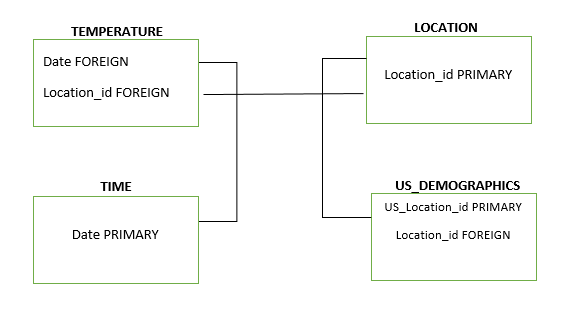

In [71]:
Image(filename='global_warming_data_model.PNG')


#### 3.2 Mapping Out Data Pipelines

Outline of all pipelines:

* Open csv datasets in Spark
                |
                v
* Wrangler data by removing duplicates, clean missing values in Spark
                |
                v
* Save four tables into csv files in Spark
                |
                v
* Drop if any of the four snowflake tables exist in Postgres
                |
                v
* Create if any of the four snowflake tables does not exist in Postgres
                |
                v
* Copy data from the 4 csv files into the snowflake tables in Postgres
                |
                v
* Drop if any of the four analytics tables exist in Postgres
                |
                v
* Create if any of the four analytics tables does not exist in Postgres
                |
                v
* Insert data into the analytics tables from pre-specified select statements in Postgres


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Here are built the data pipelines to create the data model.

In [75]:
def execute_queries(cur, conn, input_queries, file='', partitioned=False):
    """ Runs over list of queries and executes them on a given connection. 
    If partitioned is set to True, input_queries is expected to be dictionary 
    with keys as table name over which queries taken from input_query values are run"""
    if partitioned:
        for location in input_queries.keys():
            folder = copy_locations[location]
            for file in os.listdir('/home/workspace/{}'.format(folder)):
                if file[0] != '.' and file[0] != '_':
                    cur.execute(input_queries[location].format(folder, file))
    else:
        for query in input_queries:
            cur.execute(query)
            

Create a connection to Postgres server

In [73]:
conn =psycopg2.connect("host=127.0.0.1 dbname=studentdb user=student password=student")
cur = conn.cursor()
conn.set_session(autocommit=True)

Run puplines for creating snowflake schema

In [76]:
execute_queries(cur, conn, drop_snowflake_schema)

execute_queries(cur, conn, create_snowflake_schema)

execute_queries(cur, conn, copy_snowflake_schema, partitioned=True)

Run puplines for creating analytics schema

In [77]:
execute_queries(cur, conn, drop_analytics_tables)
    
execute_queries(cur, conn, create_analytics_tables)
    
execute_queries(cur, conn, insert_analytics_tables)

#### 4.2 Data Quality Checks
Two specific data quality checks are performed to ensure the pipeline ran as expected. 
 * Integrity constraints on the relational database - each of the snowflake tables have at least one not null contraint. Also, the Location table has primary key for location_id that makes each location entered in the table unique. The Time table has date as primary key which makes every date entered unique. Lastly, US_demographics has us_location_id as primary key so no duplicates of U.S. cities are entered.

* Source/Count checks to ensure completeness. There are two types of checks - completeness by counts for the snowflake and records display - for the analytics schema. For the snowflake schema as part of the cleaning process in Spark, all counts of all the four dataframes are noted down. These are use to reconcile with the Postgres tables. For the analytics tables, first 10 rows are retrieved so to ensure data is streaming in.
 
Run Quality Checks

In [78]:
counts="""select count(*) as cnt 
from {}"""

for table in data_quality_snowflake_schema.keys():
    cur.execute(counts.format(table))
    row = cur.fetchone()
    while row:
        if row[0] != data_quality_snowflake_schema[table]:
            raise ValueError ("Number of observations for {}  expected: {}, found: {}".format(table, data_quality_snowflake_schema[table], row[0]))
        row = cur.fetchone()
    

In [79]:
top_10 = """ select * from {}
                limit 10"""

for table in analytics_tables:
    cur.execute(top_10.format(table))
    print('Top 10 rows for table {}'.format(table))
    row = cur.fetchone()
    while row:
        print(row)
        row=cur.fetchone()

Top 10 rows for table yearly_average_temperature_city
(1820, 'Abadan', 'Iran', 32.877)
(1820, 'Khorramshahr', 'Iran', 32.877)
(1861, 'Guna', 'India', 32.333)
(1861, 'Lalitpur', 'India', 32.333)
(1861, 'Jhansi', 'India', 32.333)
(2013, 'Jibuti', 'Djibouti', 31.082625)
(1861, 'Ratlam', 'India', 30.813)
(1861, 'Godhra', 'India', 30.813)
(1861, 'Vejalpur', 'India', 30.813)
(2010, 'Umm Durman', 'Sudan', 30.7301666666667)
Top 10 rows for table yearly_average_temperature_country
(2013, 'Djibouti', 31.082625)
(2012, 'Djibouti', 30.2654166666667)
(2000, 'Djibouti', 30.2156666666667)
(2009, 'Djibouti', 30.2060833333333)
(2010, 'Djibouti', 30.187)
(2005, 'Djibouti', 30.1635833333333)
(2011, 'Djibouti', 30.1505)
(2007, 'Djibouti', 30.1368333333333)
(1998, 'Djibouti', 30.1325833333333)
(2006, 'Djibouti', 30.127)
Top 10 rows for table monthly_average_temperature_year
(1846, 7, 24.6283062374245)
(2010, 7, 24.5117724928367)
(2006, 7, 24.4012676217766)
(2002, 7, 24.315122922636)
(2012, 7, 24.2170234957

In [80]:
#Close postgres connection
cur.close()
conn.close()

#### 4.3 Data dictionary 
Data dictionary for the snowflake data model is created in data_dictionaty.txt. For each field, a brief description explanation is porvided of what the data is and where it came from.

#### Step 5: Complete Project Write Up
* Rationale for the choice of tools and technologies for the project.

There are few notes to add as why certain technologies have been used instead of others. 

First, Spark is used for initial analysis and clean up because of its intuitiveness to work with when cleaning data plus its capabilities of dealing with big datasets by partitioning into smaller ones. 

Second, Postgres is used instead of Apache Cassandra for example because 1) file distribution and partition is already being created by using Spark and 2) the assumption of the project is that queries used by data users are yet unknown. By giving them access to the snowflake schema, they will analyse in depth temperature data and build an understanding of their future needs. Afterwards, the data model can be build in Apache Cassandra.

Third, partitioned files for the four clean tables are being saved in csv and not the industry standard parquet format. This is due to the decision to use Postgres and the copy command. According to <https://www.postgresql.org/docs/current/sql-copy.html> the file formats that work with that function are text, csv and binary.

* How often the data should be updated and why.
Given that the natural unit of time for the temperature data is day, it makes sense to update the temperature dataset at the most daily. The potential period should not exceed a month though as the number of days mutiples with the number of cities and this can create rather high number of total observations to be appended.  

When it comes to U.S. census data, it can be updated on yearly as soon as new national statistics are published.

* How you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
 If data increased by 100 times the parallilized function in Spark would be used so to handled the huge amount of data
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 If the data is needed in a timely matter, it may be considered using Apache Airflow for scheduling purposes and creating SLAs to deliver data on time.
 * The database needed to be accessed by 100+ people.
 
 Given that the connection limit to Postgres is 100, in this situation it should be discussed switching to Cassandra as its current limit is 128. It is not a substantial improvement but it is still  